# Использование метода KNN (k-ближайших соседей)

## Импортируем данные

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, \
                            confusion_matrix, precision_score, recall_score, \
                            roc_auc_score, roc_curve, f1_score, classification_report, auc
from sklearn.preprocessing import StandardScaler # шкалирование данных
import warnings
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv('train.csv')
train.head()

,id,gravity,ph,osmo,cond,urea,calc,target
0,0,1.013,6.19,443,14.8,124,1.45,0
1,1,1.025,5.40,703,23.6,394,4.18,0
2,2,1.009,6.13,371,24.5,159,9.04,0
3,3,1.021,4.91,442,20.8,398,6.63,1
4,4,1.021,5.53,874,17.8,385,2.21,1


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       414 non-null    int64  
 1   gravity  414 non-null    float64
 2   ph       414 non-null    float64
 3   osmo     414 non-null    int64  
 4   cond     414 non-null    float64
 5   urea     414 non-null    int64  
 6   calc     414 non-null    float64
 7   target   414 non-null    int64  
dtypes: float64(4), int64(4)
memory usage: 26.0 KB


In [4]:
test = pd.read_csv('test.csv')
test.head()

,id,gravity,ph,osmo,cond,urea,calc
0,414,1.017,5.24,345,11.5,152,1.16
1,415,1.020,5.68,874,29.0,385,3.46
2,416,1.024,5.36,698,19.5,354,13.00
3,417,1.020,5.33,668,25.3,252,3.46
4,418,1.011,5.87,567,29.0,457,2.36


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276 entries, 0 to 275
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       276 non-null    int64  
 1   gravity  276 non-null    float64
 2   ph       276 non-null    float64
 3   osmo     276 non-null    int64  
 4   cond     276 non-null    float64
 5   urea     276 non-null    int64  
 6   calc     276 non-null    float64
dtypes: float64(4), int64(3)
memory usage: 15.2 KB


## Проведем EDA (Exploratory Data Analysis) - первичный анализ данных

Все данные в нашем датасете имеют числовое значение.

In [6]:
def eda_info(df):
    x = pd.DataFrame(
        {
            "Доля пропусков": df.isnull().mean(),
            "Минимальное значение": df.min(),
            "Максимальное значение": df.max(),
            "Среднее значение": df.mean(),
            "Медиана": df.median(),
            "Дисперсия": df.var(),
            "Квантиль 0.1": df.quantile(0.1),
            "Квантиль 0.9": df.quantile(0.9),
            "Квартиль 1": df.quantile(0.25),
            "Квартиль 3": df.quantile(0.75)
        }
    )
    
    return x

In [7]:
col = train.select_dtypes(include=["number"]).columns
eda_info(train[col]) # EDA для таблицы train

,Доля пропусков,Минимальное значение,Максимальное значение,Среднее значение,Медиана,Дисперсия,Квантиль 0.1,Квантиль 0.9,Квартиль 1,Квартиль 3
id,0.0,0.000,413.00,206.500000,206.500,14317.500000,41.300,371.700,103.250,309.750
gravity,0.0,1.005,1.04,1.017894,1.018,0.000045,1.008,1.025,1.012,1.022
ph,0.0,4.760,7.94,5.955459,5.740,0.412498,5.330,6.810,5.530,6.280
osmo,0.0,187.000,1236.00,651.545894,679.500,55073.091109,343.600,925.200,455.250,840.000
cond,0.0,5.100,38.00,21.437923,22.200,56.471464,10.900,29.000,15.500,27.600
urea,0.0,10.000,620.00,278.657005,277.000,18616.487396,95.000,443.000,170.000,385.000
calc,0.0,0.170,14.34,4.114638,3.130,10.353210,1.053,8.515,1.450,6.630
target,0.0,0.000,1.00,0.444444,0.000,0.247511,0.000,1.000,0.000,1.000


In [8]:
col = test.select_dtypes(include=["number"]).columns
eda_info(test[col]) # EDA для таблицы test

,Доля пропусков,Минимальное значение,Максимальное значение,Среднее значение,Медиана,Дисперсия,Квантиль 0.1,Квантиль 0.9,Квартиль 1,Квартиль 3
id,0.0,414.000,689.000,551.500000,551.500,6371.000000,441.500,661.500,482.7500,620.25000
gravity,0.0,1.005,1.034,1.018330,1.019,0.000043,1.009,1.026,1.0140,1.02325
ph,0.0,4.900,7.940,5.939312,5.730,0.368623,5.350,6.800,5.5300,6.21000
osmo,0.0,187.000,1236.000,654.891304,658.000,55866.962688,364.000,947.000,456.0000,843.25000
cond,0.0,5.100,38.000,21.886594,23.600,53.964729,11.200,29.500,17.4000,27.60000
urea,0.0,64.000,620.000,280.985507,282.000,18192.036153,95.000,457.000,168.5000,385.00000
calc,0.0,0.170,14.340,4.076848,3.230,9.538980,1.110,8.480,1.5275,5.54000


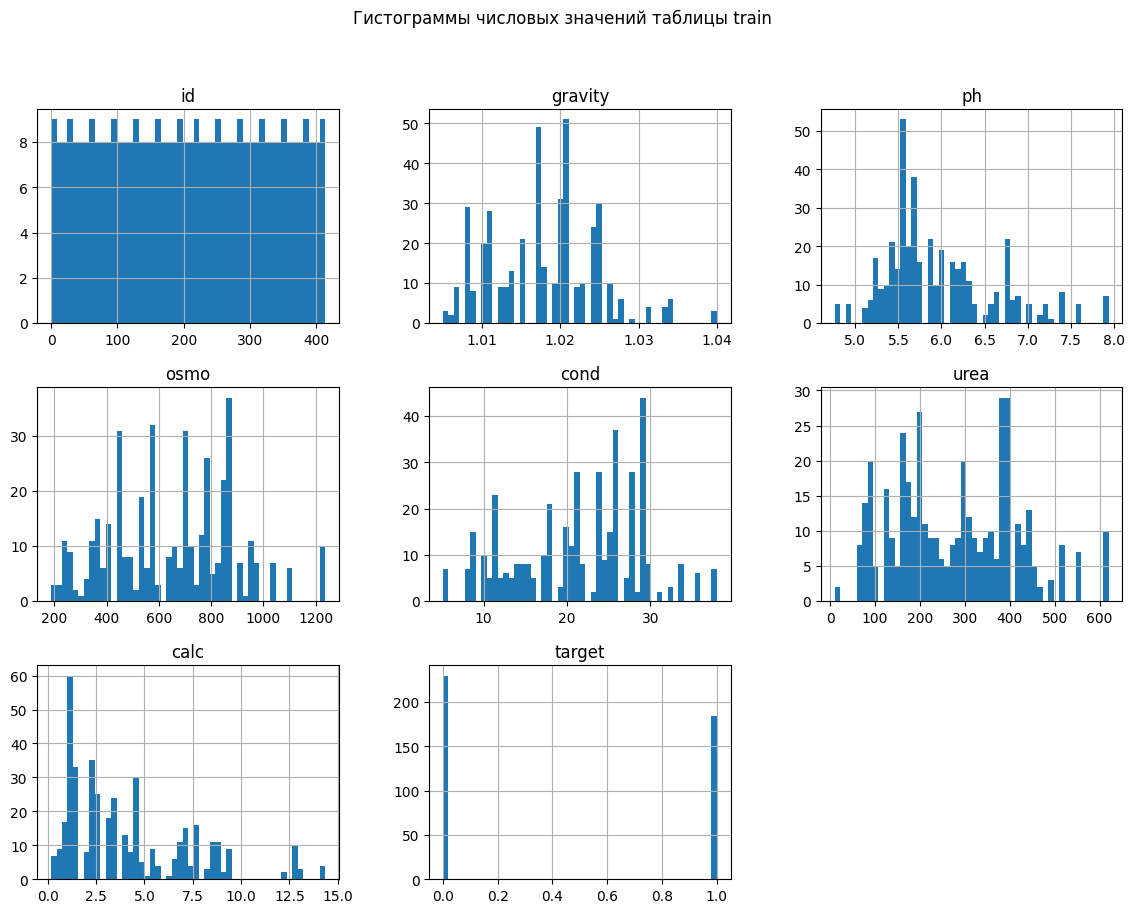

In [9]:
train.hist(bins=50, figsize=(14, 10))
plt.suptitle("Гистограммы числовых значений таблицы train")
plt.show()

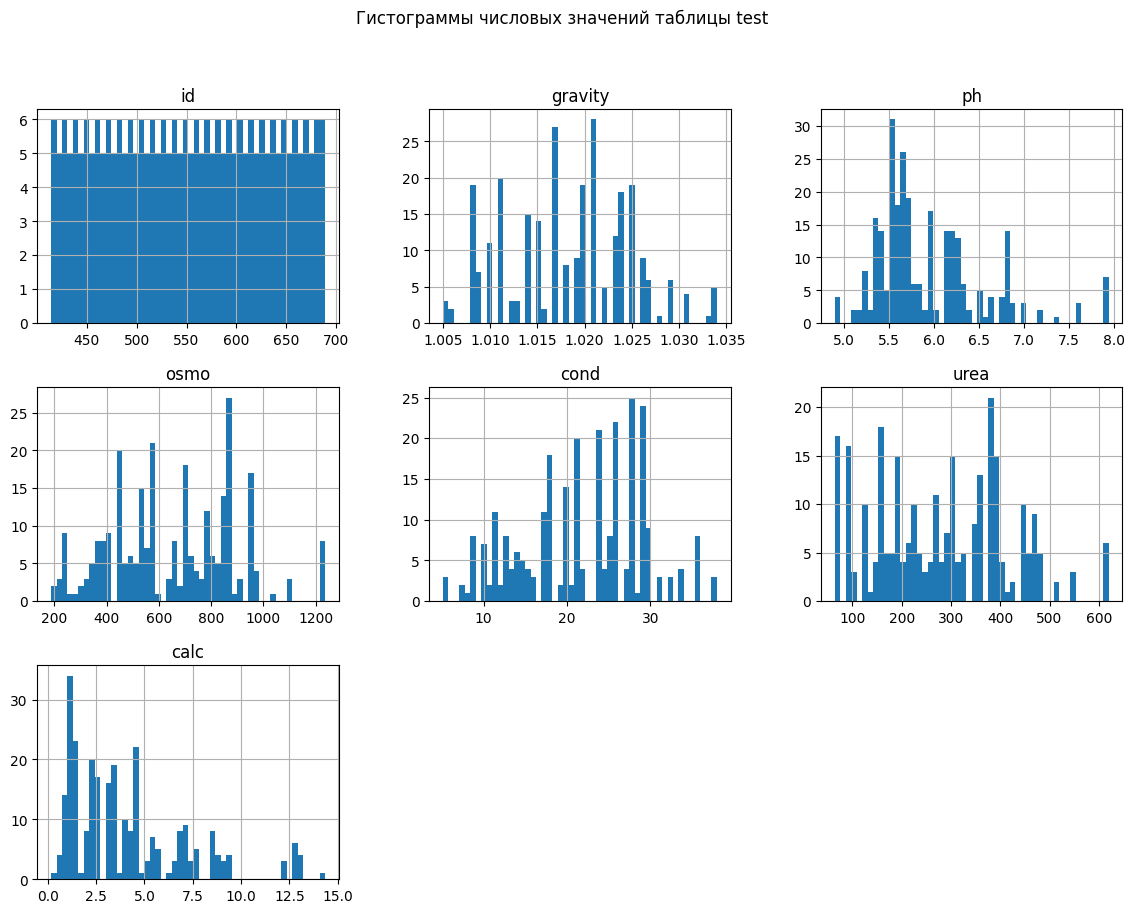

In [10]:
test.hist(bins=50, figsize=(14, 10))
plt.suptitle("Гистограммы числовых значений таблицы test")
plt.show()

В целом тренировочные и тестовые данные похожи.

## Рассмотрим целевой признак `target`

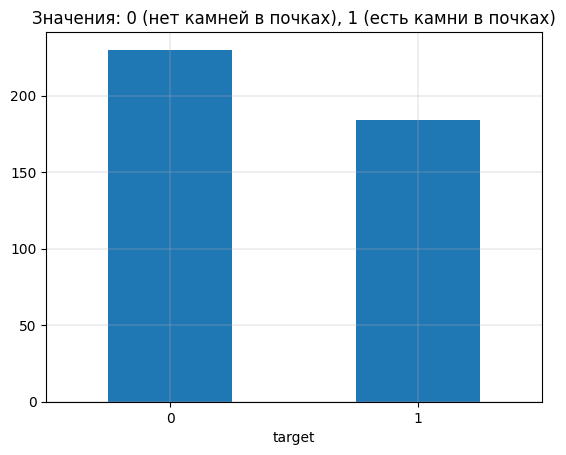

In [11]:
train['target'].value_counts().sort_index().plot(kind='bar')
plt.xticks(rotation=0)
plt.grid(linewidth=0.3)
plt.title('Значения: 0 (нет камней в почках), 1 (есть камни в почках)')
plt.show()

In [12]:
# Доля значений целевого признака
train['target'].value_counts(normalize = True)

target
0    0.555556
1    0.444444
Name: proportion, dtype: float64

Есть небольшой дисбаланс данных, учтем его в будущем при построении модели.

## Анализ данных

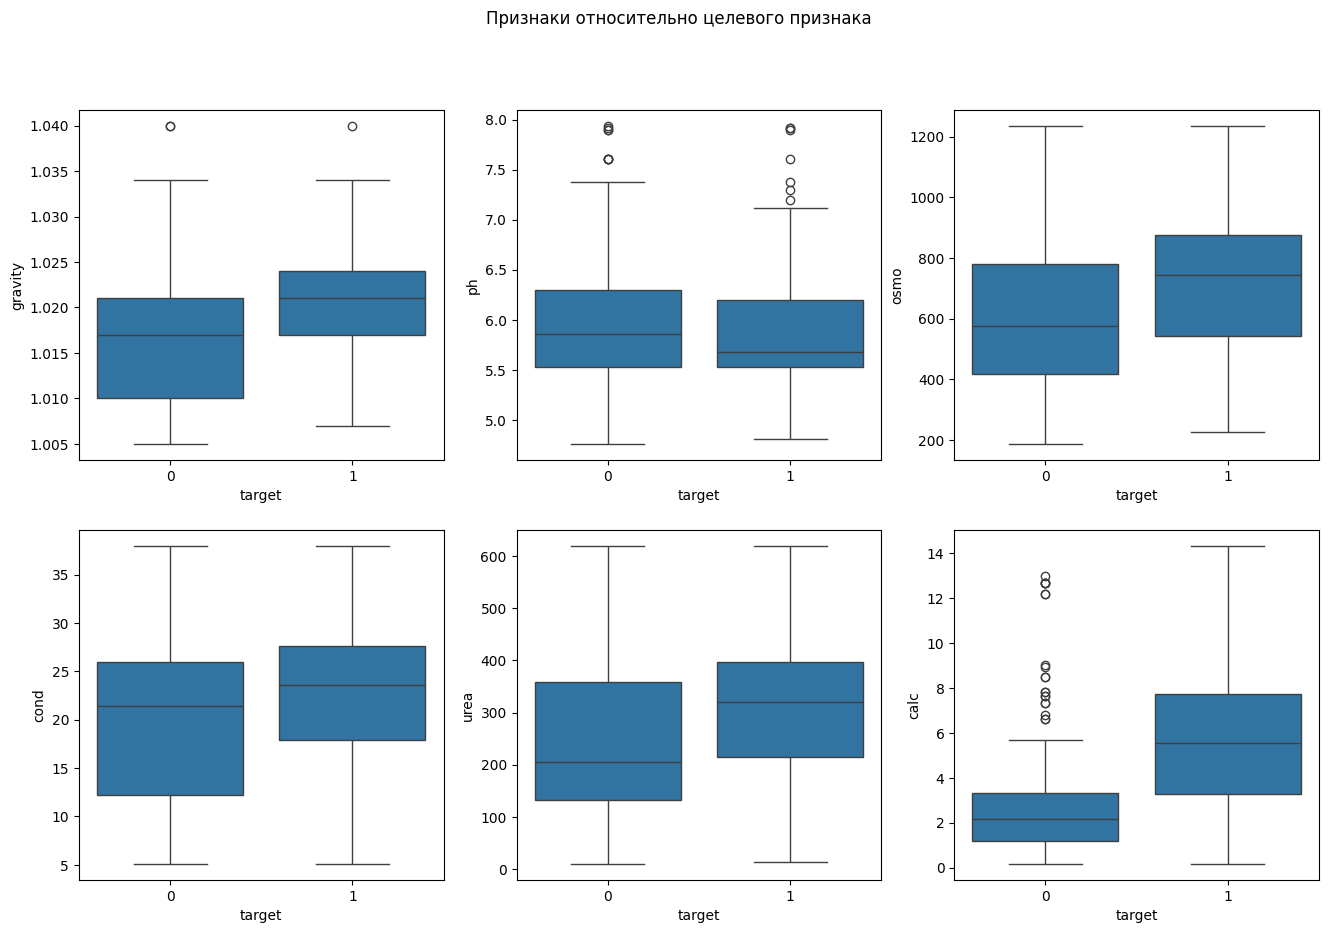

In [13]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
sns.boxplot(ax=axes[0, 0], x='target', y='gravity', data=train)
sns.boxplot(ax=axes[0, 1], x='target', y='ph', data=train)
sns.boxplot(ax=axes[0, 2], x='target', y='osmo', data=train)
sns.boxplot(ax=axes[1, 0], x='target', y='cond', data=train)
sns.boxplot(ax=axes[1, 1], x='target', y='urea', data=train)
sns.boxplot(ax=axes[1, 2], x='target', y='calc', data=train)
plt.suptitle("Признаки относительно целевого признака")
plt.show()

Видим, что в некоторых данных имеются выбросы. Пока их трогать не будем, посмотрим как с ними поведет себя модель.

### Построим матрицу корреляции

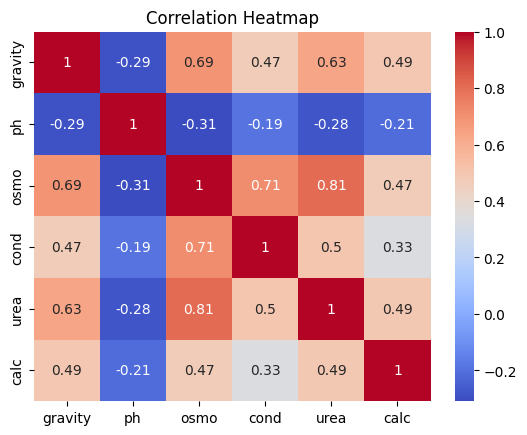

In [14]:
corr = train.drop(columns=['id', 'target']).corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

Видим хорошую корреляцию между osmo, urea и cond.

## Построим модель KNN

### Поделим нашу таблицу на тренировочную и тестовую в соотношении 80/20

In [15]:
X = train.drop(columns=['id', 'target'])
y = train['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('Размер тренировочной выборки (признаки):', X_train.shape)
print('Размер тестовой выборки (признаки):', X_test.shape)
print('Размер тренировочной выборки (целевой признак):', y_train.shape)
print('Размер тестовой выборки (целевой признак):', y_test.shape)

Размер тренировочной выборки (признаки): (331, 6)
Размер тестовой выборки (признаки): (83, 6)
Размер тренировочной выборки (целевой признак): (331,)
Размер тестовой выборки (целевой признак): (83,)


### Отшкалируем данные

In [16]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [17]:
pd.DataFrame(X_train).head()

,0,1,2,3,4,5
0,-0.932744,-0.271945,-0.866679,-0.563507,-0.646711,-0.844550
1,-0.173427,-0.364694,0.196437,0.387993,-0.087629,-0.190738
2,1.041479,1.474843,1.259554,0.910648,0.844175,-0.450993
3,-1.540197,0.052680,0.524560,-0.509901,1.015627,0.929630
4,1.952659,-1.091234,0.192062,0.267380,0.613087,2.735547


In [18]:
pd.DataFrame(X_test).head()

,0,1,2,3,4,5
0,1.041479,0.129971,1.298928,0.803437,1.425620,1.691352
1,0.434026,-1.323108,0.940181,0.991057,0.747267,0.929630
2,0.434026,-1.137609,0.288312,-0.027451,1.201987,-0.168521
3,-0.173427,0.949261,-0.437933,-0.777930,0.262729,0.418641
4,-1.084607,1.304801,-1.291051,-0.818134,-0.915071,-0.450993


### Подберем гиперпараметры для модели

In [19]:
param_grid = {
    'n_neighbors': list(range(1, 31, 2)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski', 'chebyshev'],
    'p': [1, 2, 3]
}

In [20]:
knn = KNeighborsClassifier()
grid_search = GridSearchCV(
    knn, 
    param_grid, 
    cv=5, 
    scoring=['accuracy', 'precision', 'recall', 'f1'],
    refit='f1',  # Переобучим лучшую модель по F1
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski',
                                    'chebyshev'],
                         'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21,
                                         23, 25, 27, 29],
                         'p': [1, 2, 3], 'weights': ['uniform', 'distance']},
             refit='f1', scoring=['accuracy', 'precision', 'recall', 'f1'],
             verbose=1)

In [21]:
grid_search.best_params_

{'metric': 'manhattan', 'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}

**Гиперпараметры нашей модели:**

- дистанционная метрика = `manhattan` (Манхэттенское расстояние)
- число ближайших соседей = `7`
- параметр метрики Минковского p = `1`
- метрика weights: `uniform`: одинаковые веса. Все точки имеют одинаковый вес.

Гиперпараметры получили при помощи метода *GridSearch* в основе которого лежит кросс валидация параметров и выбор самого лучшего.

In [22]:
# Обучим нашу модель на лучших полученных гиперпараметрах
knn_best = KNeighborsClassifier(**grid_search.best_params_)
knn_best.fit(X_train, y_train)

KNeighborsClassifier(metric='manhattan', n_neighbors=7, p=1)

In [23]:
y_pred = knn_best.predict(X_test) # Предсказание модели
y_pred

array([1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1])

### Метрики Accuracy, Precision, Recall, F1

In [24]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.82      0.80        45
           1       0.78      0.74      0.76        38

    accuracy                           0.78        83
   macro avg       0.78      0.78      0.78        83
weighted avg       0.78      0.78      0.78        83

Accuracy: 0.7831325301204819
Precision: 0.7829046683186649
Recall: 0.7831325301204819
F1 Score: 0.7825591437430097


### Метрика ROC-AUC

In [25]:
# AUC ROC
y_test_prob = knn_best.predict_proba(X_test)[:, 1]
print("AUC ROC:", roc_auc_score(y_test, y_test_prob))

AUC ROC: 0.7956140350877193


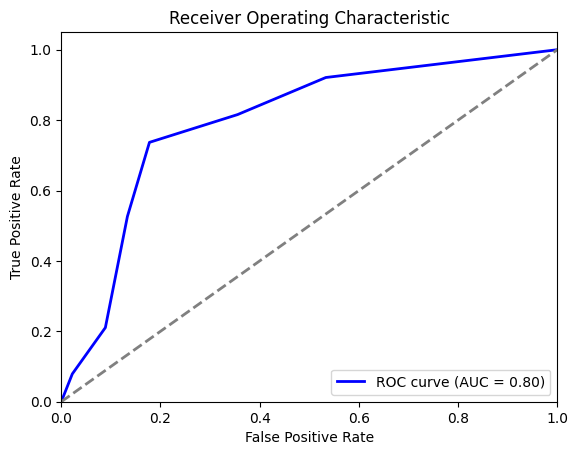

In [26]:
plt.figure()
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

При несбалансированных данных оценка **F1** обеспечит лучшую оценку эффективности модели.

**ROC-AUC** можно интерпретировать как показатель модели чьи прогнозы предсказания верны на 80%. Причем AUC не зависит от масштаба - он измеряет, насколько хорошо ранжируются прогнозы, а не их абсолютные значения и также не зависит от порога классификации - он измеряет качество прогнозов модели независимо от выбранного порога классификации.

**Accuracy** — это показатель, который описывает общую точность предсказания модели по всем классам. Это особенно полезно, когда каждый класс одинаково важен. Он рассчитывается как отношение количества правильных прогнозов к их общему количеству. Стоит учесть, что метрика **Accuracy** может быть обманчивой. Один из таких случаев — это несбалансированные данные. Поскольку при дисбалансе большинство семплов принадлежит к одному классу, **Accuracy** для этого класса будет выше, чем для другого.

Полнота **Recall** выявляет, какую долю положительных среди всех ответов выделила модель. Полнота — это доля TP-ответов среди всех, у которых истинная метка 1. Хорошо, когда значение **Recall** близко к единице: модель хорошо ищет положительные объекты.

Метрика **Precision** (точность) также известна как положительное прогнозное значение. Она измеряет вероятность того, что модель верно спрогнозировала, что значение является истинным.

### Матрица ошибок

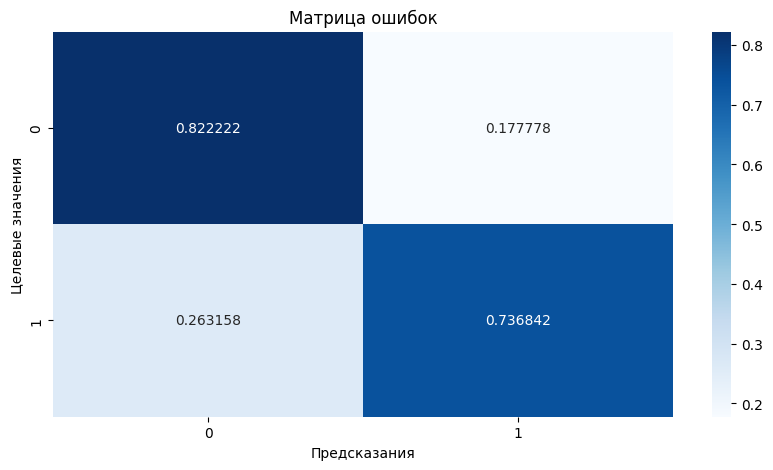

In [27]:
# Матрица ошибок
conf_matrix = confusion_matrix(y_test, y_pred, normalize='true')
plt.subplots( figsize=(10, 5))
sns.heatmap(conf_matrix, annot=True,  fmt='g', cmap='Blues')

plt.title('Матрица ошибок', fontsize=12 )
plt.xlabel('Предсказания')
plt.ylabel('Целевые значения')
plt.show()

По Матрице ошибок видна следующая картина:

- **True Positive (истинно-положительное решение)**: нет камней в почках и прогноз модели это предсказал (Предсказания 0 : Целевые значения 0) - 82%
- **False Positive (ложноположительное решение)**: ошибка 1-го рода, ML-модель предсказала что камни в почках есть, а на самом деле их нет (Предсказания 1 : Целевые значения 0) - 18%
- **False Negative (ложноотрицательное решение)**: ошибка 2-го рода – ML-модель предсказала, что камней в почках нет, но на самом деле они есть (Предсказания 0 : Целевые значения 1) - 26%
- **True Negative (истинно-отрицательное решение)**: камни в почках есть и прогноз модели это предсказал (Предсказания 1 : Целевые значения 1) - 74%

`Далее можно в обученную модель на вход подать данные test.csv и получить предсказания от модели. Но это уже совсем другая история, которая не входит в рамки домашней работы :)`